# Name: Vu Le (U43500182)
# Name: Huong Duong (U11340848)    

Development environment (Colab or local): Colab

# Deep Learning Analysis

- **Tasks:**
  1. Compare the performance of a small CNN (LeNet-5) with the results you got for PCA, LDA, and SVM using the Olivetti faces dataset
  2. Choose, implement (if not available in a library),  and run a baseline for the IMDB text classification from lecture
    - Consider what techniques would be appropriate for this task.
    - Also consider the fact that this is a text dataset, so some techniques might not work well or may be cumbersome to engineer.
    - Include a description of your baseline and explain why this baseline makes sense for this problem.
  3. Run a vanilla RNN on the IMDB text classification dataset and compare its performance against your baseline.
  4. Explore data augmentation techniques for both tasks.
    - For the image task, you may use the built-in Keras data augmentation function (tf.keras.preprocessing.image.ImageDataGenerator).
    - For the text task, you may find an external function that you import or write your own data augmentation.
    - Describe what data augmentation methods you used and the motivation behind them (why you think they'll help).

_Where it is relevant, make sure you follow deep learning best practices discussed in class. In particular, performing a hyperparameter search and setting up an proper train, dev, and test framework for evaluating hyperparameters and your final selected model._

- Evaluation scenarios:
  1. Facial Recognition
    - Use 20% of the images for training and 80% for testing
    - Use 50% of the images for training and 50% for testing
    - Use 80% of the images for training and 20% for testing
    - Always use the first K images per person for training, and the remaining ones for testing (see data split code below)
    - Plot CMC curve and confusion matrix for each combination of scenario

  2. Review Text Classification
    - Use 2,000 examples for training and 2,000 examples for testing (smaller than the example in lecture)
    - Experiment with several RNN configurations
    - Plot the training and validation plots for your RNN and for your baseline if your baseline has a training phase.
    - Plot a confusion matrix of the predictions.

- Discussion:
  1. Facial Recognition
    - Is LeNet-5 better than PCA/LDA/SVM?
    - Is there a clear difference in performance for different train/test data splits?
    - Does data augmentation improve the results?
  
  2. Review Text Classification
    - Is the vanilla RNN better than a simple baseline?
    - How sensitive is the RNN performance to hyperparameter selection?
    - Does data augmentation improve the results? More or less than for the facial recognition task? What properties of the two tasks do you think is leading to the data augmentation effects you are seeing?

## Olivetti faces dataset (AT&T Laboratories Cambridge)

As described on the original website:

"*There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).*"

The original dataset consisted of 92 x 112, while the version available here consists of 64x64 images.

- Classes: 40
- Samples per class: 10
- Samples total: 400
- Dimensionality: 4096 (64x64 pixels)
- Pixel values: real, between 0 and 1


In [ ]:
from sklearn.datasets import fetch_olivetti_faces
from google.colab.patches import cv2_imshow
import numpy as np

# Get the dataset

In [ ]:
faces = fetch_olivetti_faces()

_, img_height, img_width = faces.images.shape

print(faces.images.shape)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
(400, 64, 64)


# Split the dataset

In [ ]:
N_IDENTITIES = len(np.unique(faces.target)) # how many different individuals are in the dataset
GALLERY_SIZE = 5                            # use the first GALLERY_SIZE images per individual for training, the rest for testing

gallery_indices = []
probe_indices = []
for i in range(N_IDENTITIES):
  indices = list(np.where(faces.target == i)[0])
  gallery_indices += indices[:GALLERY_SIZE]
  probe_indices += indices[GALLERY_SIZE:]

x_train = faces.images[gallery_indices].reshape(-1, img_height, img_width, 1)
y_train = faces.target[gallery_indices]
x_test = faces.images[probe_indices].reshape(-1, img_height, img_width, 1)
y_test = faces.target[probe_indices]

print(x_train.shape, x_test.shape)

(200, 64, 64, 1) (200, 64, 64, 1)


# Visualize the splits

In [ ]:
def show_images(imgs, num_rows, num_cols):
  assert len(imgs) == num_rows*num_cols

  for i in range(num_rows):
    row = None
    for j in range(num_cols):
      if row is None:
        row = imgs[i*num_cols+j].reshape(img_height, img_width)*255.0
      else:
        row = np.concatenate((row, imgs[i*num_cols+j].reshape(img_height, img_width)*255.0), axis=1)
    cv2_imshow(row)

In [ ]:
show_images(x_train, N_IDENTITIES, GALLERY_SIZE)

In [ ]:
show_images(x_test, N_IDENTITIES, 10 - GALLERY_SIZE)

# Run the experiments

Here is the code I used to get the results below!

# Small CNN without data augmentation


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
10/10 [==============================] - 1s 43ms/step


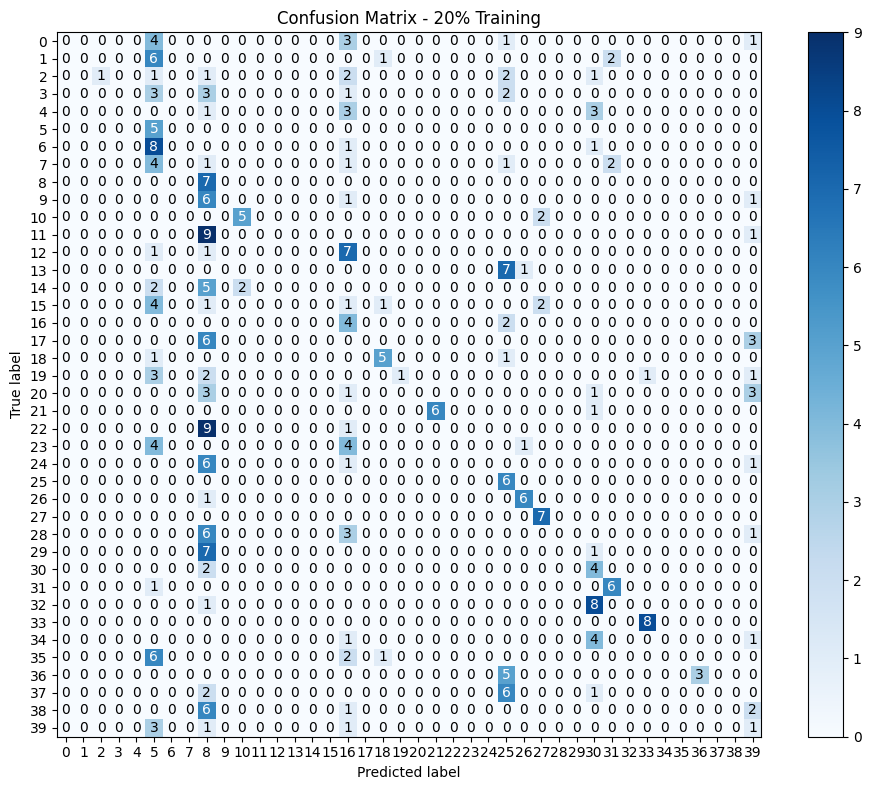

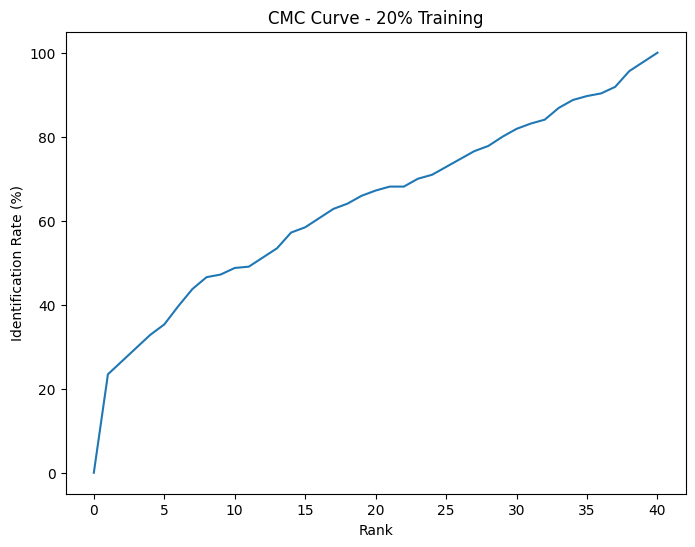

7/7 [==============================] - 1s 50ms/step


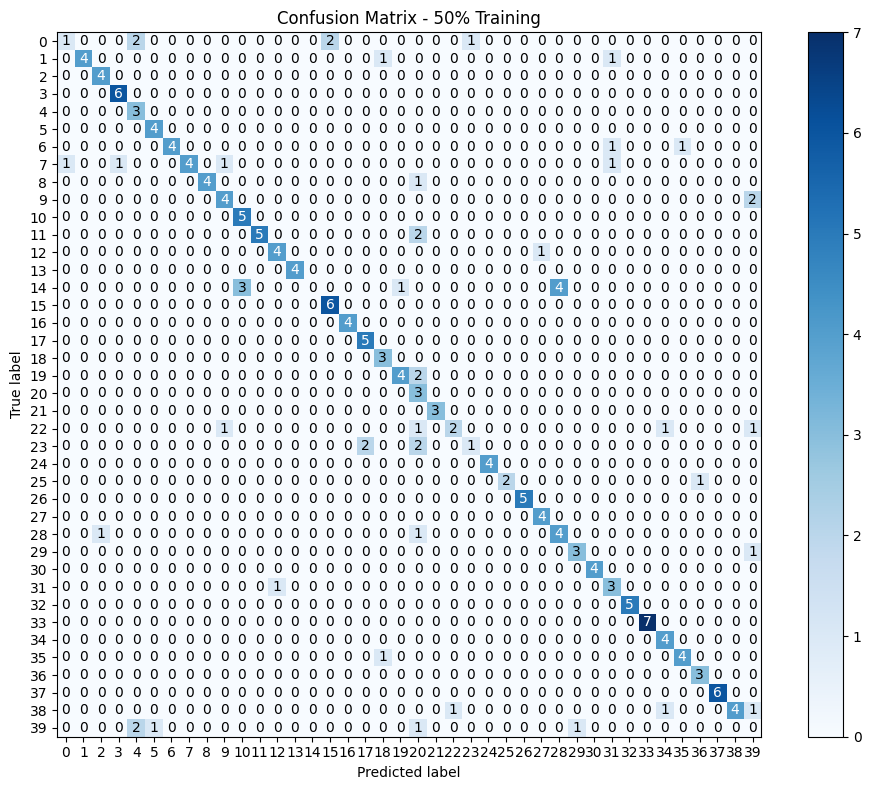

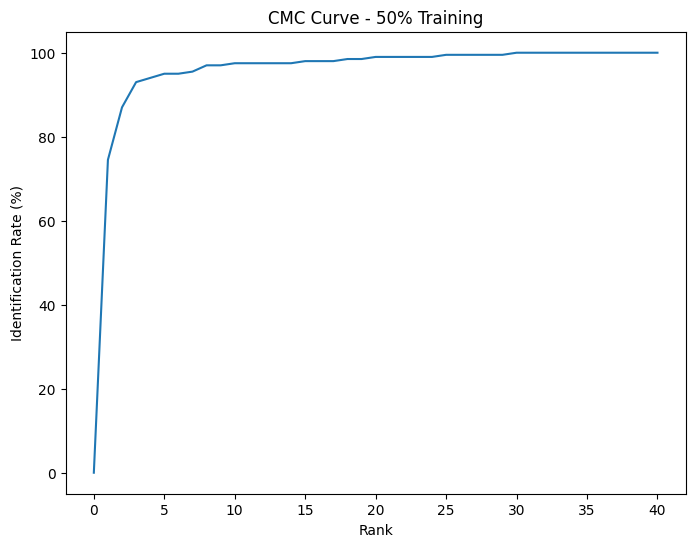

3/3 [==============================] - 0s 19ms/step


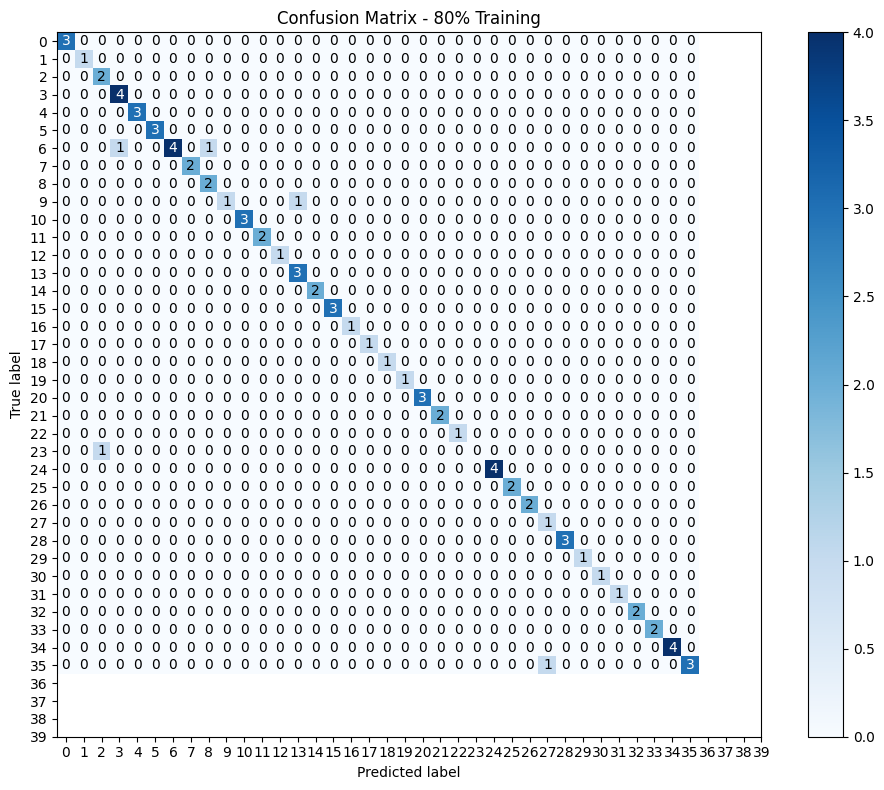

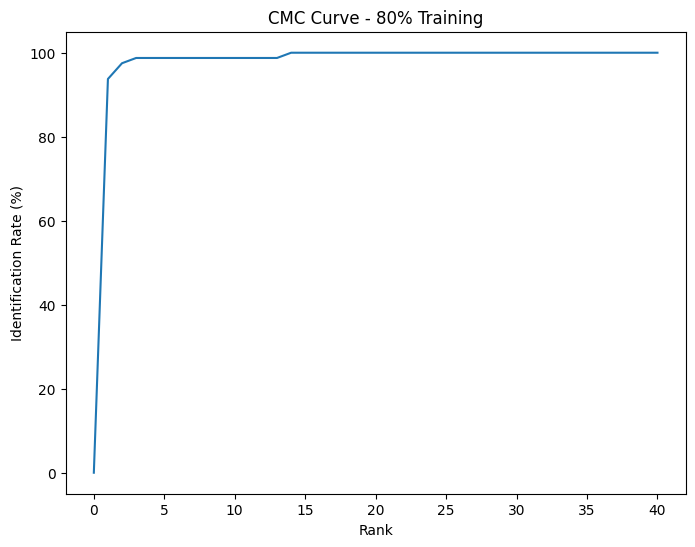

Accuracy for 20% Training: 0.23
Accuracy for 50% Training: 0.74
Accuracy for 80% Training: 0.94


In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda

# Load Olivetti faces data
faces = fetch_olivetti_faces()
X = faces.images
y = faces.target
n_classes = len(np.unique(y))

# Reshape and normalize the images for CNN
X = X.reshape(-1, 64, 64, 1).astype('float32')

# Define the LeNet-5 model
def lenet_5(in_shape=(64, 64, 1), n_classes=40):
    model = tf.keras.models.Sequential()

    # C1 Convolutional Layer
    model.add(Conv2D(filters=6, kernel_size=(3, 3), strides=(1, 1), activation='tanh', input_shape=in_shape))

    # S2 Pooling Layer
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

    # C3 Convolutional Layer
    model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation='tanh'))

    # S4 Pooling Layer
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the CNN output to feed it with fully connected layers
    model.add(Flatten())

    # C5 Fully Connected Layer
    model.add(Dense(units=120, activation='tanh'))

    # Fully Connected Layer
    model.add(Dense(units=84, activation='tanh'))

    # Output Layer
    model.add(Dense(units=n_classes, activation='softmax'))

    return model

# Initialize LeNet-5 model
model = lenet_5()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# The rest of your code remains the same, including the functions to plot the confusion matrix and CMC curve,
# and the training/testing scenarios.


# Function to plot the confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ticks = np.arange(n_classes)
    plt.xticks(ticks, ticks)
    plt.yticks(ticks, ticks)
    plt.grid(False)

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

# Plot CMC curve
def plot_cmc_curve(y_true, y_scores, ax, label, n_classes):
    y_true_onehot = label_binarize(y_true, classes=np.arange(n_classes))
    y_scores_sorted_idx = np.argsort(y_scores, axis=1)[:, ::-1]
    ranks = np.zeros(y_true.shape[0], dtype=int)
    for i in range(y_true.shape[0]):
        result = np.where(y_scores_sorted_idx[i] == y_true[i])[0]
        ranks[i] = result[0] if result.size > 0 else n_classes
    cmc_curve = np.cumsum(np.bincount(ranks, minlength=n_classes)) / len(y_true)
    cmc_curve *= 100  # Convert to percentage
    cmc_curve = np.insert(cmc_curve, 0, 0)  # Insert a zero at the beginning for plotting
    ax.plot(range(len(cmc_curve)), cmc_curve, label=label)
    ax.set_ylabel("Identification Rate (%)")

# Scenarios and methods
scenarios = {
    "20% Training": 0.2,
    "50% Training": 0.5,
    "80% Training": 0.8
}

# Dictionary to store accuracies for each scenario
scenario_accuracies = {}

for scenario_name, scenario_param in scenarios.items():
    # Split the data according to the scenario
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=scenario_param, random_state=42)

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate confusion matrix and plot
    cm = confusion_matrix(y_test, y_pred_classes)
    plot_confusion_matrix(cm, title=f'Confusion Matrix - {scenario_name}')

    # CMC curve
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f"CMC Curve - {scenario_name}")
    ax.set_xlabel("Rank")
    plot_cmc_curve(y_test, y_pred, ax, 'Lenet_5', n_classes)
    plt.show()

    # Calculate accuracy
    accuracy = np.mean(y_pred_classes == y_test)
    scenario_accuracies[scenario_name] = accuracy

# Print accuracies for each scenario
for scenario_name, accuracy in scenario_accuracies.items():
    print(f"Accuracy for {scenario_name}: {accuracy:.2f}")

# Small CNN with data augmentation


Epoch 1/20
3/3 [==============================] - 3s 100ms/step - loss: 4.0132 - accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 0s 85ms/step - loss: 3.6345 - accuracy: 0.0750
Epoch 3/20
3/3 [==============================] - 0s 75ms/step - loss: 3.6068 - accuracy: 0.0625
Epoch 4/20
3/3 [==============================] - 0s 93ms/step - loss: 3.5278 - accuracy: 0.0500
Epoch 5/20
3/3 [==============================] - 0s 107ms/step - loss: 3.4769 - accuracy: 0.0875
Epoch 6/20
3/3 [==============================] - 0s 99ms/step - loss: 3.4570 - accuracy: 0.0750
Epoch 7/20
3/3 [==============================] - 0s 168ms/step - loss: 3.4344 - accuracy: 0.0625
Epoch 8/20
3/3 [==============================] - 0s 98ms/step - loss: 3.4128 - accuracy: 0.0625
Epoch 9/20
3/3 [==============================] - 0s 73ms/step - loss: 3.3811 - accuracy: 0.1125
Epoch 10/20
3/3 [==============================] - 0s 54ms/step - loss: 3.3604 - accuracy: 0.1750
Epoch 11/20
3/3 [=====

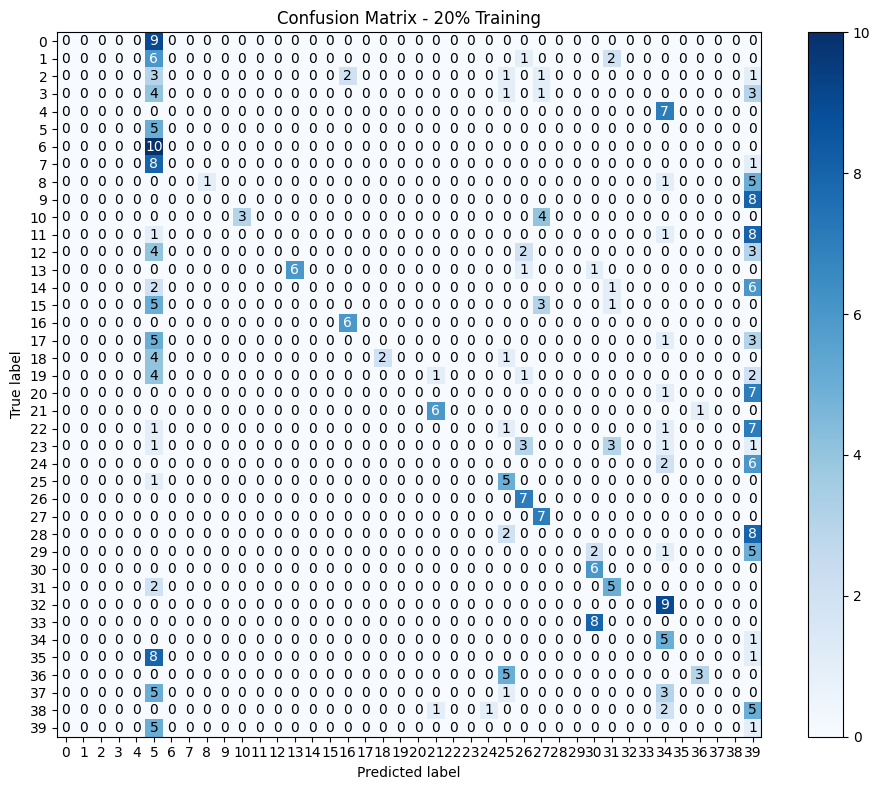

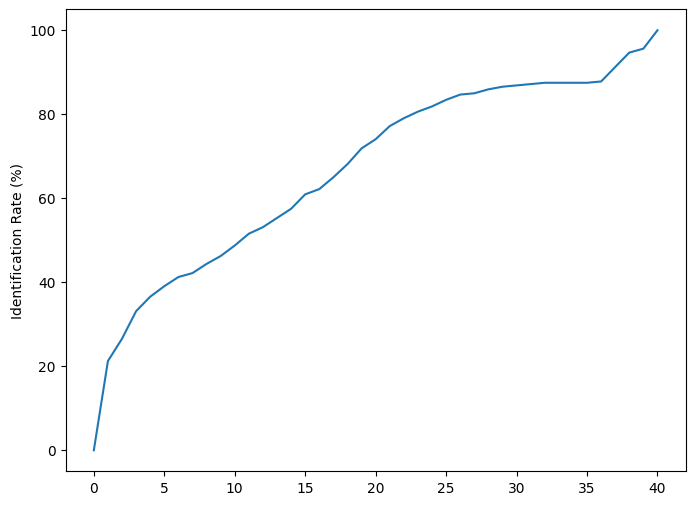

Epoch 1/20
7/7 [==============================] - 0s 55ms/step - loss: 3.1091 - accuracy: 0.3150
Epoch 2/20
7/7 [==============================] - 0s 56ms/step - loss: 2.9141 - accuracy: 0.3100
Epoch 3/20
7/7 [==============================] - 0s 53ms/step - loss: 2.6555 - accuracy: 0.3950
Epoch 4/20
7/7 [==============================] - 0s 57ms/step - loss: 2.5537 - accuracy: 0.3950
Epoch 5/20
7/7 [==============================] - 0s 68ms/step - loss: 2.3151 - accuracy: 0.4650
Epoch 6/20
7/7 [==============================] - 0s 59ms/step - loss: 2.1640 - accuracy: 0.5100
Epoch 7/20
7/7 [==============================] - 0s 58ms/step - loss: 2.0638 - accuracy: 0.5150
Epoch 8/20
7/7 [==============================] - 0s 57ms/step - loss: 1.9621 - accuracy: 0.5500
Epoch 9/20
7/7 [==============================] - 0s 58ms/step - loss: 1.7326 - accuracy: 0.6450
Epoch 10/20
7/7 [==============================] - 0s 58ms/step - loss: 1.6986 - accuracy: 0.6550
Epoch 11/20
7/7 [============

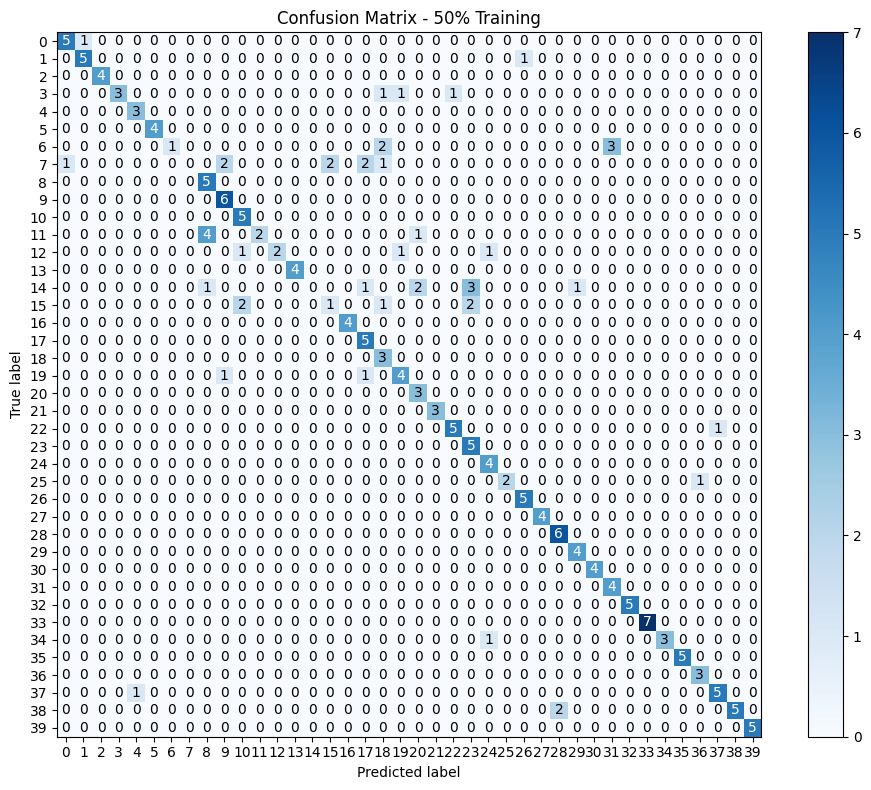

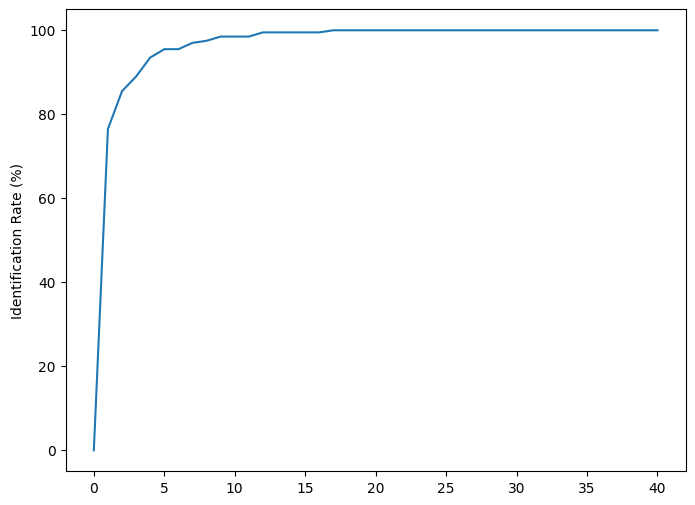

Epoch 1/20
10/10 [==============================] - 1s 67ms/step - loss: 1.0832 - accuracy: 0.8000
Epoch 2/20
10/10 [==============================] - 1s 69ms/step - loss: 0.9643 - accuracy: 0.8313
Epoch 3/20
10/10 [==============================] - 1s 67ms/step - loss: 0.9599 - accuracy: 0.8156
Epoch 4/20
10/10 [==============================] - 1s 135ms/step - loss: 0.8409 - accuracy: 0.8375
Epoch 5/20
10/10 [==============================] - 2s 119ms/step - loss: 0.8164 - accuracy: 0.8625
Epoch 6/20
10/10 [==============================] - 1s 68ms/step - loss: 0.7492 - accuracy: 0.8687
Epoch 7/20
10/10 [==============================] - 1s 65ms/step - loss: 0.7027 - accuracy: 0.8875
Epoch 8/20
10/10 [==============================] - 1s 67ms/step - loss: 0.6201 - accuracy: 0.9250
Epoch 9/20
10/10 [==============================] - 1s 65ms/step - loss: 0.6206 - accuracy: 0.9156
Epoch 10/20
10/10 [==============================] - 1s 65ms/step - loss: 0.5648 - accuracy: 0.9125
Epoch 1

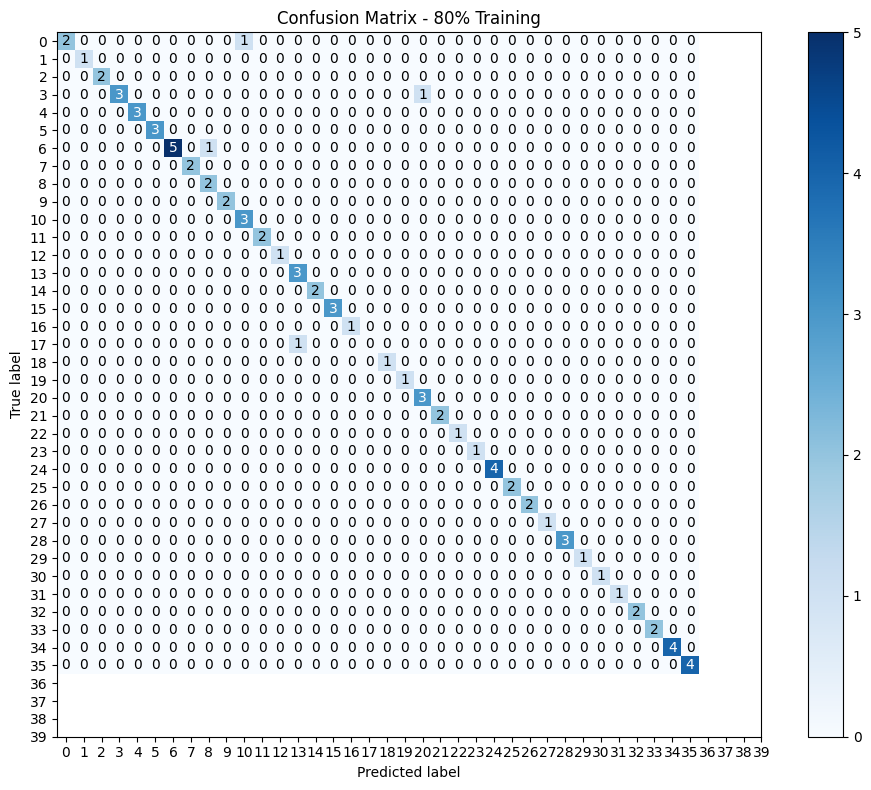

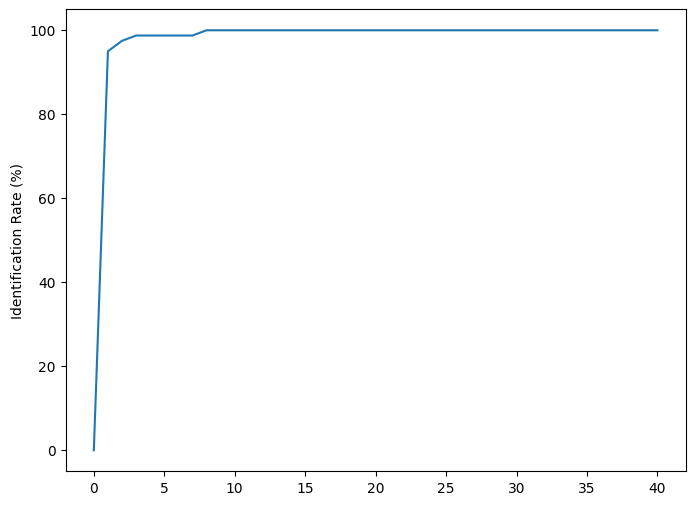

Accuracy for 20% Training: 0.21
Accuracy for 50% Training: 0.77
Accuracy for 80% Training: 0.95


In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

# Load Olivetti faces data
faces = fetch_olivetti_faces()
X = faces.images
y = faces.target
n_classes = len(np.unique(y))

# Reshape and normalize the images for CNN
X = X.reshape(-1, 64, 64, 1).astype('float32')

# Define the LeNet-5 model
def lenet_5(in_shape=(64, 64, 1), n_classes=40):
    model = tf.keras.models.Sequential([
        Conv2D(6, (3, 3), activation='tanh', input_shape=in_shape),
        AveragePooling2D((2, 2)),
        Conv2D(16, (3, 3), activation='tanh'),
        AveragePooling2D((2, 2)),
        Flatten(),
        Dense(120, activation='tanh'),
        Dense(84, activation='tanh'),
        Dense(n_classes, activation='softmax')
    ])
    return model

# Initialize LeNet-5 model
model = lenet_5()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Data Augmentation Generator
data_generator = ImageDataGenerator(
    rotation_range=10,  # reduced rotation range
    width_shift_range=0.05,  # reduced shift range
    height_shift_range=0.05,  # reduced shift range
    zoom_range=0.1,  # reduced zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ticks = np.arange(n_classes)
    plt.xticks(ticks, ticks)
    plt.yticks(ticks, ticks)
    plt.grid(False)

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

# Plot CMC curve
def plot_cmc_curve(y_true, y_scores, ax, label, n_classes):
    y_true_onehot = label_binarize(y_true, classes=np.arange(n_classes))
    y_scores_sorted_idx = np.argsort(y_scores, axis=1)[:, ::-1]
    ranks = np.zeros(y_true.shape[0], dtype=int)
    for i in range(y_true.shape[0]):
        result = np.where(y_scores_sorted_idx[i] == y_true[i])[0]
        ranks[i] = result[0] if result.size > 0 else n_classes
    cmc_curve = np.cumsum(np.bincount(ranks, minlength=n_classes)) / len(y_true)
    cmc_curve *= 100  # Convert to percentage
    cmc_curve = np.insert(cmc_curve, 0, 0)  # Insert a zero at the beginning for plotting
    ax.plot(range(len(cmc_curve)), cmc_curve, label=label)
    ax.set_ylabel("Identification Rate (%)")

# Training/testing scenarios
scenarios = {
    "20% Training": 0.2,
    "50% Training": 0.5,
    "80% Training": 0.8
}

# Dictionary to store accuracies for each scenario
scenario_accuracies = {}

# Iterate over scenarios
for scenario_name, scenario_param in scenarios.items():
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=scenario_param, random_state=42)

    # Data Augmentation
    train_generator = data_generator.flow(X_train, y_train, batch_size=32)

    # Train the model with augmented data
    model.fit(train_generator, epochs=20, verbose=1)  # increased epochs

    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate confusion matrix and plot
    cm = confusion_matrix(y_test, y_pred_classes)
    plot_confusion_matrix(cm, title=f'Confusion Matrix - {scenario_name}')

    # CMC curve
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_cmc_curve(y_test, y_pred, ax, 'Lenet_5', n_classes)
    plt.show()

    # Calculate accuracy
    accuracy = np.mean(y_pred_classes == y_test)
    scenario_accuracies[scenario_name] = accuracy

# Print accuracies for each scenario
for scenario_name, accuracy in scenario_accuracies.items():
    print(f"Accuracy for {scenario_name}: {accuracy:.2f}")

# IMDB Movie Review Dataset
Description from https://www.tensorflow.org/datasets/catalog/imdb_reviews:
> Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.

In [ ]:
import tensorflow_datasets
import tensorflow as tf
import numpy as np
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import nlpaug.augmenter.word as naw
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# !pip install --upgrade tensorflow
# !pip install nlpaug



Load dataset

In [ ]:
dataset, info = tensorflow_datasets.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Get subset of the data for training and testing (2000 samples each). Convert Keras dataset to lists of strings and labels.

In [ ]:
x_train = []
y_train = []

for sample, label in train_dataset.take(2000):
  x_train.append(sample.numpy())
  y_train.append(label.numpy())

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

print(x_train[0])
print(y_train[0])

x_test = []
y_test = []

for sample, label in test_dataset.take(2000):
  x_test.append(sample.numpy())
  y_test.append(label.numpy())

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print(x_test[0])
print(y_test[0])

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
0
b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of th

# Add your baseline

Here is the code for my baseline, along with an explanation of how it works and why it makes sense for this problem.

In [ ]:
# 0 -> negative; 1 -> positive
vectorizer = TfidfVectorizer(max_features=1000) # use TF-IDF for determining the frequency of a word in a collection
x_train_vector = vectorizer.fit_transform([sentence.decode('utf-8') for sentence in x_train]) # transform the training and test data using the TF-IDF vectorizer
x_test_vector = vectorizer.transform([sentence.decode('utf-8') for sentence in x_test])

SVM = SVC()
SVM.fit(x_train_vector, y_train) # train SVM using TF-IDF training data
pred = SVM.predict(x_test_vector) # predict labels using TF-IDF test data
accuracy = accuracy_score(y_test, pred) # calculate accuracy
print(accuracy)

# We chose SVM for our task because they are good for binary classification problems. Our problem is involves classifying texts into either Positive or Negative classes, which is binary.
# SVM's are effective with high-dimensional data. Because we are working with texts, each word will represent a dimension, so SVM's are useful because they perform well in cases with a large
# feature space. SVM is effective when the data is linearly separable. With text classification, even though the feature space is high-dimensional, SVM can find a hyperplane
# that effectively separates the classes (positive and negative).

0.8225


# Vanilla RNN

In [ ]:
def clean_text(sentence):
  cleaned = re.sub('<.*?>', ' ', sentence)
  cleaned = re.sub(r'[^\w\s]', '', cleaned)
  return cleaned

vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=1000, output_mode='int', output_sequence_length=1146)

x_train_decoded = [clean_text(sentence.decode('utf-8')) for sentence in x_train]
x_test_decoded = [clean_text(sentence.decode('utf-8')) for sentence in x_test]
vectorize_layer.adapt(x_train_decoded)
x_train_vectorized = vectorize_layer(x_train_decoded).numpy()
x_test_vectorized = vectorize_layer(x_test_decoded).numpy()



In [ ]:


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=1000, output_dim=128, mask_zero=True),
    tf.keras.layers.SimpleRNN(units=128, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.SimpleRNN(units=64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

history = model.fit(x_train_vectorized, y_train, epochs=10, batch_size=32, validation_data=(x_test_vectorized, y_test))


Epoch 1/10
63/63 [==============================] - 53s 822ms/step - loss: 0.6935 - accuracy: 0.4970 - val_loss: 0.6931 - val_accuracy: 0.4945
Epoch 2/10
63/63 [==============================] - 52s 825ms/step - loss: 0.6913 - accuracy: 0.5585 - val_loss: 0.6931 - val_accuracy: 0.5110
Epoch 3/10
63/63 [==============================] - 51s 820ms/step - loss: 0.6893 - accuracy: 0.5895 - val_loss: 0.6928 - val_accuracy: 0.5210
Epoch 4/10
63/63 [==============================] - 52s 828ms/step - loss: 0.6861 - accuracy: 0.6335 - val_loss: 0.6921 - val_accuracy: 0.5275
Epoch 5/10
63/63 [==============================] - 51s 817ms/step - loss: 0.6801 - accuracy: 0.6520 - val_loss: 0.6915 - val_accuracy: 0.5240
Epoch 6/10
63/63 [==============================] - 52s 829ms/step - loss: 0.6682 - accuracy: 0.7075 - val_loss: 0.6872 - val_accuracy: 0.5470
Epoch 7/10
63/63 [==============================] - 51s 819ms/step - loss: 0.6409 - accuracy: 0.7160 - val_loss: 0.6799 - val_accuracy: 0.5580

63/63 [==============================] - 9s 137ms/step


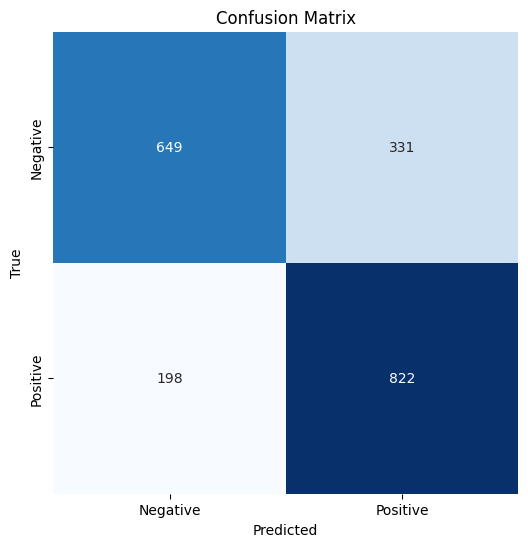

(0.0, 0.7122655212879181)

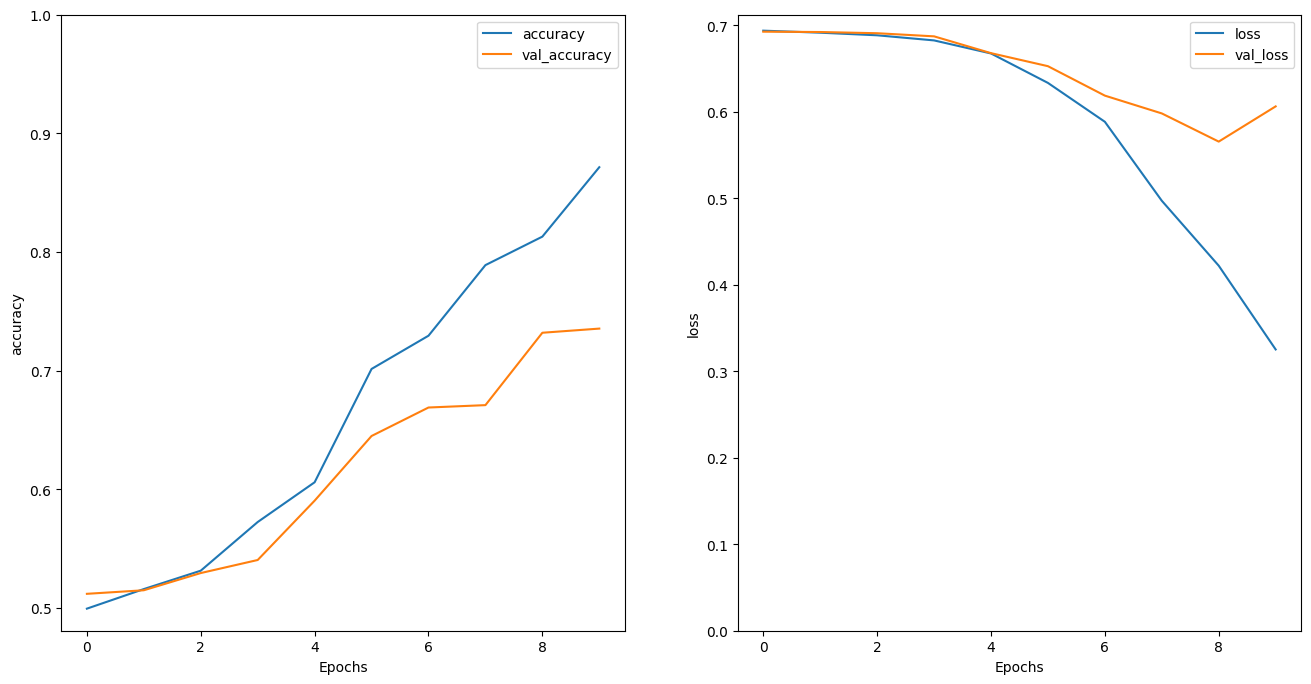

In [ ]:
# # Make predictions on the test set
predictions = (model.predict(x_test_vectorized) > 0.5).astype("int32")

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

#Data Augmentation - IMDB Reviews

In [ ]:
def synonym_replacement(sentence):
  aug = naw.SynonymAug(aug_src='wordnet')
  augmented_text = aug.augment(sentence)
  return augmented_text

def random_insertion(sentence):
  aug = naw.RandomWordAug()
  augmented_text = aug.augment(sentence)
  return augmented_text

def random_swap(sentence):
  aug = naw.RandomWordAug(action="swap")
  augmented_text = aug.augment(sentence)
  return augmented_text

x_train_augmented = []
y_train_augmented = []

for i in range(len(x_train)):
    label = y_train[i]

    # Original sentence
    x_train_augmented.append(x_train_decoded[i])
    y_train_augmented.append(label)

    # Augmented sentences
    x_train_augmented.append(synonym_replacement(x_train_decoded[i]))
    y_train_augmented.append(label)

    x_train_augmented.append(random_insertion(x_train_decoded[i]))
    y_train_augmented.append(label)

    x_train_augmented.append(random_swap(x_train_decoded[i]))
    y_train_augmented.append(label)


In [ ]:
x_train_augmented_flattened = [sentence if isinstance(sentence, str) else ' '.join(sentence) for sentence in x_train_augmented]

x_train_augmented_vectorized = vectorize_layer(x_train_augmented_flattened).numpy()

y_train_augmented_np = np.array(y_train_augmented)

history_augmented = model.fit(x_train_augmented_vectorized, y_train_augmented_np, epochs=10, batch_size=32, validation_data=(x_test_vectorized, y_test))

Epoch 1/10
250/250 [==============================] - 191s 762ms/step - loss: 0.6905 - accuracy: 0.5344 - val_loss: 0.6921 - val_accuracy: 0.5020
Epoch 2/10
250/250 [==============================] - 188s 751ms/step - loss: 2.6711 - accuracy: 0.6190 - val_loss: 0.6837 - val_accuracy: 0.5630
Epoch 3/10
250/250 [==============================] - 199s 796ms/step - loss: 0.6210 - accuracy: 0.7434 - val_loss: 0.6689 - val_accuracy: 0.5915
Epoch 4/10
250/250 [==============================] - 193s 772ms/step - loss: 0.5101 - accuracy: 0.7965 - val_loss: 0.6553 - val_accuracy: 0.6260
Epoch 5/10
250/250 [==============================] - 185s 738ms/step - loss: 0.3735 - accuracy: 0.8526 - val_loss: 0.6556 - val_accuracy: 0.6615
Epoch 6/10
250/250 [==============================] - 187s 748ms/step - loss: 0.2522 - accuracy: 0.9091 - val_loss: 0.6626 - val_accuracy: 0.6920
Epoch 7/10
250/250 [==============================] - 184s 736ms/step - loss: 0.1784 - accuracy: 0.9400 - val_loss: 0.6775 -

#Discussion


1. Facial Recognition

 - Is LeNet-5 better than PCA/LDA/SVM?
 - Is there a clear difference in performance for different train/test data splits?
 - Does data augmentation improve the results?

2. Review Text Classification

 - Is the vanilla RNN better than a simple baseline?
 - How sensitive is the RNN performance to hyperparameter selection?
 - Does data augmentation improve the results? More or less than for the facial recognition task? What properties of the two tasks do you think is leading to the data augmentation effects you are seeing?

# Facial Recognition

Old results:

- Results for 20% Training, 80% Testing: {'KNN': 0.63125, 'PCA': 0.63125, 'LDA': 0.634375, 'SVM': 0.55}
- Results for 50% Training, 50% Testing: {'KNN': 0.865, 'PCA': 0.855, 'LDA': 0.925, 'SVM': 0.84}
- Results for 80% Training, 20% Testing: {'KNN': 0.9125, 'PCA': 0.9125, 'LDA': 0.975, 'SVM': 0.9625}

Current results:
- Lenet5 without data augmentation:
  - Accuracy for 20% Training: 0.23
  - Accuracy for 50% Training: 0.74
  - Accuracy for 80% Training: 0.94

- Lenet5 with data augmentation:
  - Accuracy for 20% Training: 0.21
  - Accuracy for 50% Training: 0.77
  - Accuracy for 80% Training: 0.95
  - Discussion about the data augmentation and reasons:
    - Rotation (10 degrees):
    Images are slightly turned, up to 10 degrees, to help the model learn from different angles of faces that are not perfectly straight or upright

    - Width and Height Shift (5%):
    Images are shifted sideways or up/down by a small amount to teach the model to recognize off-center faces.

    - Zoom (10%):
    Some images are made to appear closer or farther away, helping the model identify faces at various distances.

    - Horizontal Flip:
    Images are mirrored to help the model recognize faces from different angles.

    - Fill Mode ('nearest'):
    Empty spots in images are filled with nearby pixels to maintain a normal appearance after adjustments.

    - Overall the model will get better at recognizing faces no matter how they're positioned or how far away they are
    
Comparing LeNet-5 and Other Methods (PCA/LDA/SVM):

- Without Data Augmentation: When we don't use extra training data, LeNet-5 is sometimes as good or a bit better than KNN, PCA, and LDA, but not as good as SVM, especially when only a little bit of data is used for training (like 20%). However, when lots of data is used (like 80%), LeNet-5 is much better than these three methods.

- With Data Augmentation: When we add more data for training, LeNet-5 works better or about the same in the 50% and 80% training situations. But when training with less data (20%), it doesn't do as well as it does without the extra data. Still, it's better than SVM in this case.

Does More Training Data Help?

- Yes, definitely. All methods, including LeNet-5, work better when they're trained with more data. This makes sense because more data means the method can learn better and make better guesses. This is true for both the usual methods (PCA/LDA/SVM) and LeNet-5, whether we add extra training data or not.

Does Adding More Data for Training Make a Difference?

- It's a bit hard to talk about that for LeNet-5. When we have a medium or a lot of training data (50% and 80%), adding more helps a little bit. On the other hand with little training data (20%), adding more doesn't really help and might even make things a bit worse. This could be because the model doesn't have enough data to understand and generalize from the diverse examples, so it gets confused.


Overally, LeNet-5, especially when it's trained with data augmentation, is often better or just as good as the other methods like PCA, LDA, and SVM (especially when the percentage of trained data is high). This proves that CNNs (such as LeNet-5) are really good at detecting patterns in images, sometimes outperforming other methods

# Review Text Classification

Is the vanilla RNN better than a simple baseline?


- The vanilla RNN performs better than a simple baseline in training. With the baseline, we got an accuracy of .8225. With the RNN, our training accuracy was .8670, but it had a lower testing accuracy with .6150. This discrepancy suggests potential overfitting.

How sensitive is the RNN performance to hyperparameter selection?

- The performance of our RNN is quite sensitive to hyperparameter selection. Given the difference between our training and testing accuracy, there are some signs of overfitting, where our model might be too specialized to our training data. Some hyperparameters we tweaked to help with this included number of epochs, batch sizes, learning rates, and changing the RNN architecture (adding/configuring layers). We also messed around with early stops and L2 regularization.

Does data augmentation improve the results? More or less than for the facial recognition task? What properties of the two tasks do you think is leading to the data augmentation effects you are seeing?

- Yes, the data augmentation helped improve results.  Our augmented data had a training accuracy of .9875 and a testing accuracy of .7215. This improvement was less than the improvement seen with augmenting data in facial recognition. However, it was an improvement from the original dataset.

- For augmenting data with texts, we used multiple methods. The first method was synonym replacement, where we replaced words in the text with synonyms. Then, we used random insertion, which inserts random words into the text. This helps the model become more robust to variations in sentence structure. We also used random swap, which randomly swaps the positions of two words in the text, introducing variability in word order. For each review in our dataset, we performed each augmentation on it and appended it to our dataset.

In text classification, particularly for sentiment analysis tasks like IMDB reviews, the meaning of the text heavily depends on the specific words used and their order. Simple augmentations like synonym replacement, random insertion, or random swapping might alter the meaning or sentiment of the text, leading to a potential decrease in classification performance. Moreover, the language structure and semantics are complex, making it challenging to generate meaningful variations through augmentation. For our task, augmentations aim to create diverse but semantically similar variants of the input text. The impact of these augmentations depends mostly on the size of the data and diversity of words used in the dataset.

For facial recognition tasks, augmentations can be beneficial for improving model generalization, especially when dealing with variations in pose, illumination, and facial expressions. These augmentations are designed to simulate real-world scenarios where lighting conditions, poses, or orientations of faces may vary. Augmentations in image data are generally more intuitive and can help the model generalize better to unseen variations. This allows the model to be more robust and helps in recognizing different representations.

